Cargando datos... esto puede tardar unos segundos.
¡Datos cargados! Tenemos 87554 latidos registrados.
Cada latido está compuesto por 188 puntos de datos (el último es la etiqueta).


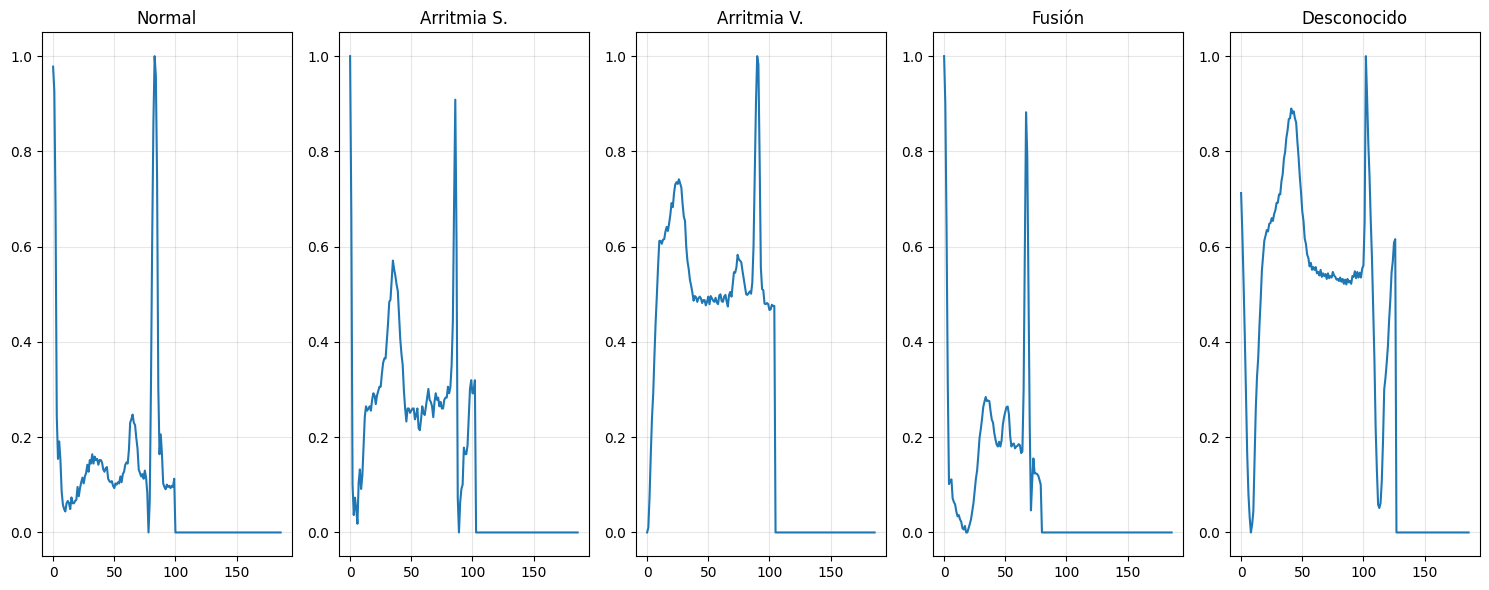


--- DISTRIBUCIÓN DE CLASES (DESBALANCEO) ---
Normal         72471
Arritmia S.     2223
Arritmia V.     5788
Fusión           641
Desconocido     6431
Name: count, dtype: int64

Nota: Fíjate en la enorme diferencia entre 'Normal' y las Arritmias.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Cargando datos... esto puede tardar unos segundos.")
# Asegúrate de que la ruta sea correcta según dónde tengas el archivo
df = pd.read_csv('sample_data/mitbih_train.csv', header=None)

print(f"¡Datos cargados! Tenemos {df.shape[0]} latidos registrados.")
print(f"Cada latido está compuesto por {df.shape[1]} puntos de datos (el último es la etiqueta).")

# Diccionario de clases
# 0: Normal, 1: Arritmia Supraventricular, 2: Ventricular, 3: Fusión, 4: Desconocido
nombres_clases = {0: 'Normal', 1: 'Arritmia S.', 2: 'Arritmia V.', 3: 'Fusión', 4: 'Desconocido'}

# --- VISUALIZACIÓN ---
plt.figure(figsize=(15, 6))
plot_position = 1

for i in range(5):
    # Filtramos por clase (la columna 187 es la etiqueta)
    subset = df[df[187] == i]

    if len(subset) > 0:
        latido = subset.iloc[0, :-1] # Tomamos el primer ejemplo, excluyendo la etiqueta
        plt.subplot(1, 5, plot_position)
        plt.plot(latido)
        plt.title(f"{nombres_clases[i]}")
        plt.grid(True, alpha=0.3)
    else:
        plt.subplot(1, 5, plot_position)
        plt.text(0.5, 0.5, "Sin datos", ha='center', va='center')
        plt.title(f"{nombres_clases[i]}")

    plot_position += 1

plt.tight_layout()
plt.show()

# --- REVISIÓN DEL DESBALANCEO ---
# Contamos cuántas filas hay de cada clase en la columna 187
counts = df[187].value_counts().sort_index()
# Le ponemos nombres bonitos a los índices
counts.index = [nombres_clases.get(idx, idx) for idx in counts.index]

print("\n--- DISTRIBUCIÓN DE CLASES (DESBALANCEO) ---")
print(counts)
print("\nNota: Fíjate en la enorme diferencia entre 'Normal' y las Arritmias.")

In [4]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# --- PARTE NUEVA: Preparación de variables (Puente desde 'df') ---
# Separamos los latidos (X) de las etiquetas (y)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# IMPORTANTE: Ajustamos la forma para la Red Neuronal (Conv1D)
# Conv1D espera (n_muestras, tiempo, canales) -> (n, 187, 1)
X = X.reshape(len(X), 187, 1)

# Convertimos las etiquetas a formato "One-Hot" (ej: 2 -> [0, 0, 1, 0, 0])
# Esto es necesario para la función de pérdida 'categorical_crossentropy'
y = to_categorical(y)

print("Datos transformados para la IA:")
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# --- TU CÓDIGO ORIGINAL (División y Pesos) ---

# 1. Separamos en Train y Test (ESTRATIFICADO)
# Como 'y' ahora es one-hot, sacamos los enteros para estratificar correctamente
y_integers = np.argmax(y, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_integers
)

# 2. Calculamos los pesos de las clases
# Usamos y_train transformado a enteros para calcular qué clases faltan
y_train_integers = np.argmax(y_train, axis=1)
unique_classes = np.unique(y_train_integers)

class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_integers
)

# Convertimos a diccionario para Keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("-" * 30)
print(f"Dimensiones Train: {X_train.shape}")
print(f"Dimensiones Test: {X_test.shape}")
print(f"Pesos calculados (esto compensará el desbalanceo): {class_weights_dict}")

Datos transformados para la IA:
Forma de X: (87554, 187, 1)
Forma de y: (87554, 5)
------------------------------
Dimensiones Train: (70043, 187, 1)
Dimensiones Test: (17511, 187, 1)
Pesos calculados (esto compensará el desbalanceo): {0: np.float64(0.2416234023837039), 1: np.float64(7.878852643419573), 2: np.float64(3.0256155507559397), 3: np.float64(27.307212475633527), 4: np.float64(2.722759961127308)}


In [5]:
import numpy as np
from sklearn.utils import shuffle

# --- AUMENTO DE DATOS VECTORIZADO (Mucho más rápido) ---
def augment_data_fast(X, y):
    print("🧠 Generando variantes de los latidos (Data Augmentation)...")

    # 1. Copia Normal
    X_orig = X
    y_orig = y

    # 2. Copia movida a la IZQUIERDA (Shift -15)
    # Usamos np.roll que mueve todo el bloque de golpe (instantáneo)
    X_left = np.roll(X, -15, axis=1)
    # Rellenamos el hueco que deja el desplazamiento con 0s
    X_left[:, -15:, :] = 0

    # 3. Copia movida a la DERECHA (Shift +15)
    X_right = np.roll(X, 15, axis=1)
    X_right[:, :15, :] = 0

    # Concatenamos todo (Original + Izq + Der)
    X_aug = np.concatenate([X_orig, X_left, X_right], axis=0)
    y_aug = np.concatenate([y_orig, y_orig, y_orig], axis=0)

    return X_aug, y_aug

# Aplicamos la función optimizada
# Usamos las variables X_train, y_train que definimos en la celda anterior
X_train_aug, y_train_aug = augment_data_fast(X_train, y_train)

# Mezclamos
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)

print(f"Latidos originales: {len(X_train)}")
print(f"Latidos finales para entrenar: {len(X_train_aug)} (x3 datos)")
print("¡Aumento completado instantáneamente!")

🧠 Generando variantes de los latidos (Data Augmentation)...
Latidos originales: 70043
Latidos finales para entrenar: 210129 (x3 datos)
¡Aumento completado instantáneamente!


In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

print("⏳ Cargando datos de prueba OFICIALES (Test Set Final)...")

# 1. Leemos el archivo de test
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Separamos X e y
# CAMBIO CLAVE: Usamos '_final' en el nombre para no borrar tu conjunto de validación
X_test_final = test_df.iloc[:, :-1].values
y_test_final = test_df.iloc[:, -1].values

# 3. Adaptamos la forma para la CNN
X_test_final = X_test_final.reshape(len(X_test_final), 187, 1)

# 4. One-hot encoding
y_test_final = to_categorical(y_test_final, num_classes=5)

print(f"✅ ¡Listo! Datos para el EXAMEN FINAL cargados.")
print(f"Muestras de Test Final: {len(X_test_final)}")
print("NOTA: Usa 'X_test' (del split anterior) en el model.fit como validación.")
print("      Usa 'X_test_final' (este nuevo) solo para el reporte final.")

⏳ Cargando datos de prueba OFICIALES (Test Set Final)...
✅ ¡Listo! Datos para el EXAMEN FINAL cargados.
Muestras de Test Final: 21892
NOTA: Usa 'X_test' (del split anterior) en el model.fit como validación.
      Usa 'X_test_final' (este nuevo) solo para el reporte final.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

# 1. Definimos la arquitectura (El esqueleto de la IA)
model = Sequential()

# Capa 1: Ojo experto (detecta patrones simples)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(187, 1)))
model.add(MaxPool1D(pool_size=2))

# Capa 2: Ojo más experto (detecta patrones complejos)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))

# Capa 3: Aplanar la información para tomar decisiones
model.add(Flatten())

# Capa 4: Neuronas de decisión
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Apagamos neuronas al azar para evitar memorización

# Capa 5: Salida (5 neuronas, una por cada tipo de arritmia)
model.add(Dense(5, activation='softmax'))

# 2. Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. ¡ENTRENAMOS! (Esto tardará un par de minutos)
print("Entrenando la red neuronal... observa cómo sube el 'accuracy'")
# Entrenamos con los datos AUMENTADOS
history = model.fit(
    X_train_aug,      # <--- CAMBIO AQUÍ
    y_train_aug,      # <--- CAMBIO AQUÍ
    epochs=10,        # Con 8-10 épocas suele sobrar porque hay muchos datos
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict
)

Entrenando la red neuronal... observa cómo sube el 'accuracy'


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 145s 22ms/step - accuracy: 0.5904 - loss: 0.8741 - val_accuracy: 0.8226 - val_loss: 0.4761
Epoch 2/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 126s 19ms/step - accuracy: 0.7740 - loss: 0.4641 - val_accuracy: 0.8647 - val_loss: 0.4189
Epoch 3/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 126s 19ms/step - accuracy: 0.8125 - loss: 0.4012 - val_accuracy: 0.8567 - val_loss: 0.4236
Epoch 4/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 125s 19ms/step - accuracy: 0.8381 - loss: 0.3471 - val_accuracy: 0.8368 - val_loss: 0.4129
Epoch 5/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 147s 20ms/step - accuracy: 0.8436 - loss: 0.3296 - val_accuracy: 0.8941 - val_loss: 0.3189
Epoch 6/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 139s 19ms/step - accuracy: 0.8492 - loss: 0.3020 - val_accuracy: 0.8998 - val_loss: 0.3098
Epoch 7/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.8627 - loss: 0.2906 - val_accuracy: 0.9318 - val_loss: 0.2090
Epoch 8/10
6567/6567 ━━━━━━━━━━━━━━━━━━━━ 127s 19ms/step - accuracy: 

📂 Cargando el archivo de TEST oficial (mitbih_test.csv)...
✅ Datos cargados: 21892 latidos para evaluar.
🧠 La IA está evaluando los latidos...
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

          RESULTADOS DEL EXAMEN FINAL (TEST SET)
                      precision    recall  f1-score   support

          Normal (N)       0.99      0.92      0.95     18118
Supraventricular (S)       0.38      0.79      0.51       556
     Ventricular (V)       0.84      0.92      0.88      1448
          Fusión (F)       0.24      0.91      0.38       162
     Desconocido (Q)       0.93      0.98      0.96      1608

            accuracy                           0.92     21892
           macro avg       0.68      0.91      0.74     21892
        weighted avg       0.96      0.92      0.93     21892



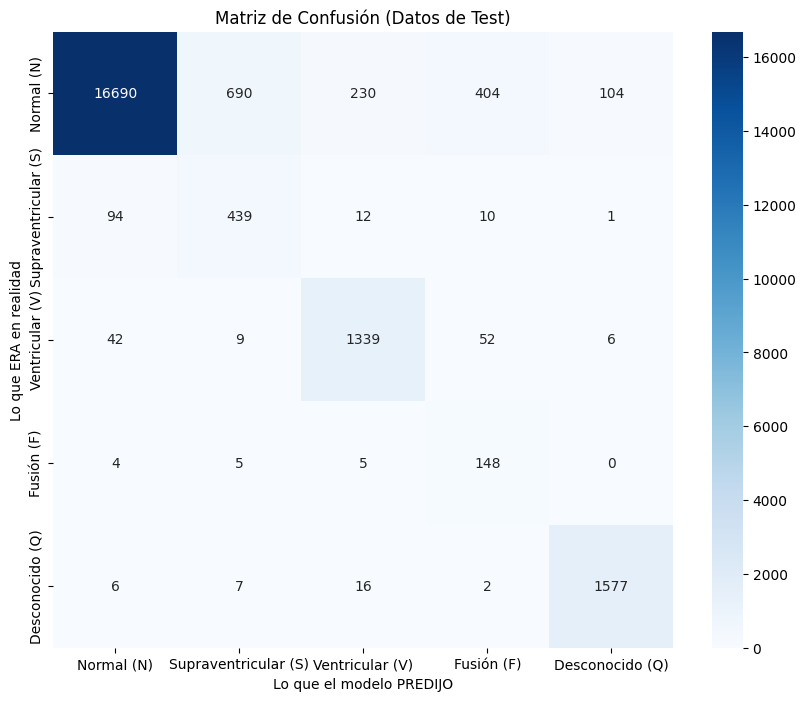


🏆 Accuracy Balanceado Final: 0.9060


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("📂 Cargando el archivo de TEST oficial (mitbih_test.csv)...")

# 1. Cargar los datos de TEST (Nunca vistos por la IA)
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Preprocesar (Separar X e y)
X_test_final = test_df.iloc[:, :-1].values
y_test_final = test_df.iloc[:, -1].values # Etiquetas reales (0, 1, 2...)

# 3. Darle la forma correcta para la red (Reshape)
X_test_final = X_test_final.reshape(len(X_test_final), 187, 1)

print(f"✅ Datos cargados: {len(X_test_final)} latidos para evaluar.")

# 4. OBTENER PREDICCIONES
print("🧠 La IA está evaluando los latidos...")
y_pred_prob = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred_prob, axis=1) # Convertimos prob -> clase (0-4)

# Definimos nombres para que se entienda el reporte
nombres_clases = ['Normal (N)', 'Supraventricular (S)', 'Ventricular (V)', 'Fusión (F)', 'Desconocido (Q)']

# 5. REPORTE PROFESIONAL (Precision, Recall, F1)
print("\n" + "="*60)
print("          RESULTADOS DEL EXAMEN FINAL (TEST SET)")
print("="*60)
print(classification_report(y_test_final, y_pred_classes, target_names=nombres_clases))

# 6. MATRIZ DE CONFUSIÓN VISUAL
cm = confusion_matrix(y_test_final, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nombres_clases,
            yticklabels=nombres_clases)
plt.title('Matriz de Confusión (Datos de Test)')
plt.ylabel('Lo que ERA en realidad')
plt.xlabel('Lo que el modelo PREDIJO')
plt.show()

# 7. Accuracy Balanceado (Opcional, pero recomendado)
from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(y_test_final, y_pred_classes)
print(f"\n🏆 Accuracy Balanceado Final: {bal_acc:.4f}")

In [ ]:
model.save('modelo_v2.keras')

In [9]:
# 1. Guardar el modelo en formato .keras (el estándar actual)
model.save('modelo_v2.keras')

print("¡Modelo guardado exitosamente!")

# 2. (Opcional) Código para descargarlo a tu ordenador automáticamente
from google.colab import files
files.download('modelo_v2.keras')

¡Modelo guardado exitosamente!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import pandas as pd

df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Filtrar una ventricular (clase 2)
row = df[df[187] == 2.0].iloc[0]

features = row.iloc[:187]  # señal
label = int(row.iloc[187]) # debería ser 2
print(label)  # para verificar que es ventricular


2


In [23]:
features.to_csv("ventricular_real.csv", index=False, header=False)


In [24]:
import pandas as pd
import os

# Ruta donde quieres guardar los CSV
OUTPUT_DIR = "sample_data/LATIDOS"

# Crear la carpeta si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar el conjunto de test
df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Diccionario de clases
clases = {
    0: "normal",
    1: "supraventricular",
    2: "ventricular",
    3: "fusion",
    4: "desconocido"
}

# Número de nuevos ejemplos que quieres por clase
N_EXAMPLES = 5

for clase_id, clase_nombre in clases.items():
    # Filtrar filas de esa clase
    subset = df[df[187] == clase_id]

    # Saltamos la primera fila (ya usada antes) y cogemos las siguientes N_EXAMPLES
    subset = subset.iloc[1:1 + N_EXAMPLES]

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        features = row.iloc[:187].values.reshape(1, 187)

        # Ruta completa del archivo dentro de LATIDOS/
        filename = os.path.join(OUTPUT_DIR, f"latido_{clase_nombre}_extra{i}.csv")

        pd.DataFrame(features).to_csv(filename, index=False, header=False)
        print("Guardado:", filename)



Guardado: sample_data/LATIDOS/latido_normal_extra1.csv
Guardado: sample_data/LATIDOS/latido_normal_extra2.csv
Guardado: sample_data/LATIDOS/latido_normal_extra3.csv
Guardado: sample_data/LATIDOS/latido_normal_extra4.csv
Guardado: sample_data/LATIDOS/latido_normal_extra5.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_fusion_extra1.csv
Guardado: sample_data/LATIDOS/latido_fusion_e

In [13]:
!pip install shap

In [28]:
import shap
import tensorflow as tf
import numpy as np

# Si solo tienes y_test_final en one-hot, lo convertimos a enteros
try:
    y_test_final_int
except NameError:
    y_test_final_int = np.argmax(y_test_final, axis=1)  # (n_muestras,)


# 1. Seleccionamos un 'fondo' para comparar
# SHAP necesita saber qué es "lo normal". Le damos 100 latidos al azar del entrenamiento.
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# 2. Creamos el Explainer (el "Explicador")
# Usamos DeepExplainer que está optimizado para Deep Learning
explainer = shap.DeepExplainer(model, background)

# 3. Elegimos qué latidos queremos explicar
# Vamos a coger 5 latidos del set de TEST (que la IA no conocía)
# Intentemos coger algunos que sepamos que son arritmias (clase 2 por ejemplo) para ver qué detecta
indices_arritmia = np.where(y_test_final_int == 2)[0][:3]
test_samples = X_test_final[indices_arritmia]

# 4. Calculamos los valores SHAP (esto puede tardar unos segundos)
print("Calculando explicaciones... (la IA está pensando)")
shap_values = explainer.shap_values(test_samples)

# Nota: shap_values es una lista de 5 arrays (uno por cada posible clase de salida).
# Nos interesa la clase 2 (Arritmia Ventricular) porque son ejemplos de esa clase.
shap_values_target = shap_values[2] # Miramos la explicación para la clase "Arritmia V."




Calculando explicaciones... (la IA está pensando)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 187, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3, 187, 1))']
  warnings.warn(msg)


Visualizando latido con dimensiones correctas: (187, 1)


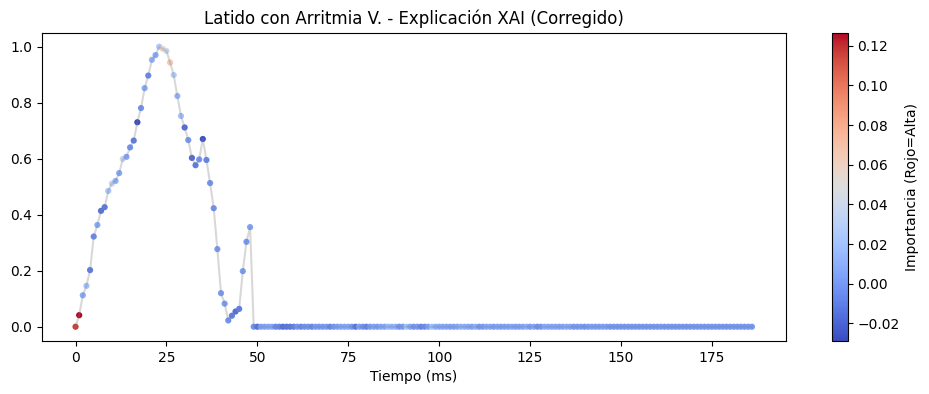

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINIMOS LA FUNCIÓN DE DIBUJO (La herramienta) ---
def plot_ecg_xai_robust(signal, shap_values, title="Explicación del Modelo"):
    # Aplanamos los datos para evitar errores de dimensión
    signal_flat = np.squeeze(signal)
    shap_flat = np.squeeze(shap_values)

    # Comprobación de seguridad
    if signal_flat.shape != shap_flat.shape:
        print(f"⚠️ Aviso: Ajustando tamaños automáticamente ({signal_flat.shape} vs {shap_flat.shape})")
        min_len = min(len(signal_flat), len(shap_flat))
        signal_flat = signal_flat[:min_len]
        shap_flat = shap_flat[:min_len]

    # Dibujamos
    plt.figure(figsize=(12, 4))
    plt.plot(signal_flat, color='gray', alpha=0.3, label='Señal ECG')

    # Coloreamos según importancia (SHAP)
    shap_min, shap_max = np.min(shap_flat), np.max(shap_flat)
    plt.scatter(range(len(signal_flat)), signal_flat,
                c=shap_flat, cmap='coolwarm',
                s=20, edgecolor='none',
                vmin=shap_min, vmax=shap_max)

    plt.colorbar(label='Importancia (Rojo=Alta)')
    plt.title(title)
    plt.xlabel('Tiempo (ms)')
    plt.show()

# --- 2. PREPARAMOS LOS DATOS (La corrección clave) ---
# Seleccionamos el PRIMER latido de los 3 que calculamos
indice_latido = 0
raw_signal = test_samples[indice_latido]

# AQUI ESTA LA CORRECCIÓN:
# Accedemos a [latido 0] -> [todos los tiempos] -> [canal 0] -> [Clase 2: Arritmia V.]
raw_shap = shap_values[indice_latido][:, 0, 2]

# --- 3. EJECUTAMOS ---
print(f"Visualizando latido con dimensiones correctas: {raw_signal.shape}")
plot_ecg_xai_robust(raw_signal, raw_shap, title="Latido con Arritmia V. - Explicación XAI (Corregido)")